# Patch-Detector

## 1. Introduction

**Where's Waldo** is a popular book consisting of a collection of highly diverse and chaotic images where the reader must attempt to locate **Waldo** within the scene. The problem of finding Waldo using computer programs is longstanding and well-known for being extremely challenging due to the complexity, variability, and large size of the images.




The core idea is to apply a **sliding window** that scans across the entire image. At each step, the model attempts to detect whether Waldo is present within the window. The detector is designed to operate on windows of a fixed size, so we begin with a model trained to classify 64×64 images as either **waldo** or **notwaldo**.

## 2. Visual Inspection of the Dataset

We are going to analyze the dataset to better understand how to approach this problem. We will show two images (one from each class), plus an additional one from the manually created samples. We will only use the colored 64×64 photos, so we will not load the others into our directory.

In [36]:
import os
import matplotlib.pyplot as plt
from PIL import Image

raw_data_path = "../data/raw_data" #path to full folder
waldo_folder = "waldo" #path to folder of positive class images
nowaldo_folder = "notwaldo" #path to folder of negative class images
expanded_data_path = "../data/expanded_data" #path to expanded data

waldo_image_example = Image.open(os.path.join(raw_data_path,waldo_folder,"1_4_6_hard.jpg")).convert("RGB")

not_waldo_image_example = Image.open(os.path.join(raw_data_path,nowaldo_folder,"1_0_0.jpg")).convert("RGB")

#### Waldo Image

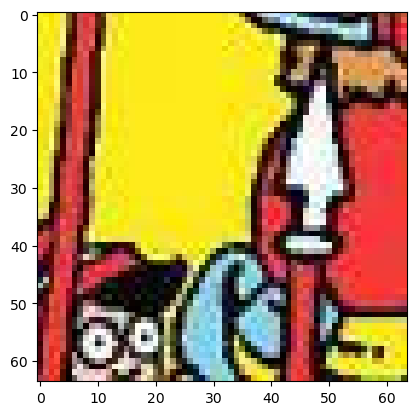

In [37]:
plt.imshow(waldo_image_example)

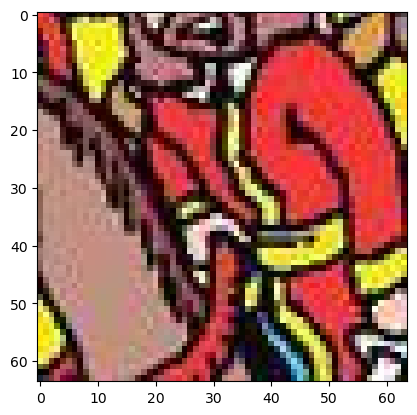

In [38]:
plt.imshow(not_waldo_image_example)

We can observe that the Waldo image contains Waldo, but not fully. Additionally, it only captures a small portion of the scene and is surrounded by various colors, which shows that Waldo images do not always present Waldo clearly. The Not Waldo image, taken from below the previous one, displays many different colors and patterns.

## 3. Data Preprocessing

### 3.1 Manual Cropping

To maximize our model’s capacity, we created a few additional Waldo images from the dataset and removed the majority of images that did not show Waldo clearly.

Using the "Waldo-Extractor.ipynb" script, we extracted crops of Waldo that displayed him more clearly and simply, avoiding the more challenging configurations originally provided by the dataset. This was saved in the `expanded_data` folder.



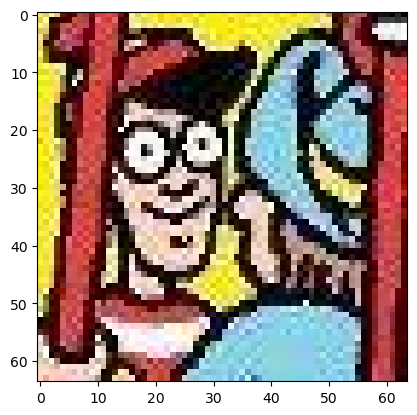

In [39]:
manual_waldo_image_example = Image.open(os.path.join(expanded_data_path,waldo_folder,"waldo1.jpg")).convert("RGB")

plt.imshow(manual_waldo_image_example)

For technical reasons, we will now define an image preprocessor. The rationale behind this preprocessing is related to the model we will use, but for now, we will focus solely on the preprocessing steps.

In [40]:
import numpy as np
import torch
import torchvision
from torch.utils import data
from torchvision import transforms    
from torch.utils.data import random_split
from torch import nn

In [41]:
preprocesser = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #This normalization will be required by our model
])

This preprocessor will first resize the images to 256×256 (significantly larger than 64×64) and then crop the central 224×224 region. Although resizing directly to 224×224 might seem more straightforward, it can distort the image in undesired ways.

### 3.1 Data Separation

We will start by dividing the expanded dataset into a training set and a test set. This step should be done before applying any type of data augmentation to avoid data leakage.

Data leakage happens when information from the test set unintentionally influences the training process, leading to overly optimistic evaluation results that don’t reflect real-world performance. If you apply data augmentation before splitting, augmented versions of the same original image could appear in both the training and test sets. This means the model could effectively “see” test images during training, which compromises the integrity of the evaluation.

We created the code below with a function that ensures the `split_dataset` folder does not accumulate repeated images by deleting all files inside it beforehand if the folder already exists.


In [42]:
expanded_data_path = "../data/expanded_data" #path to expanded data


In [43]:
import os
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image

output_dir = "../data/split_dataset" #output directory

test_size = 0.2 # we used a small size because we want to take advantage of all maximum amount of images
random_state = 42

def clear_and_create_dir(path): # function to clean the directory and avoid duplicate files
    if os.path.exists(path):
        shutil.rmtree(path)  
    os.makedirs(path)      
    
for split in ['train', 'test']: 
    split_dir = os.path.join(output_dir, split)
    clear_and_create_dir(split_dir)

images = []
labels = []

for label in os.listdir(expanded_data_path):
    class_dir = os.path.join(expanded_data_path, label)
    if not os.path.isdir(class_dir):
        continue
    for img_name in os.listdir(class_dir):
        if img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
            images.append(os.path.join(class_dir, img_name))
            labels.append(label)

train_imgs, test_imgs, train_labels, test_labels = train_test_split(
    images, labels, test_size=test_size, stratify=labels, random_state=random_state
)

for split in ['train', 'test']:
    split_dir = os.path.join(output_dir, split)
    for label in set(labels):
        os.makedirs(os.path.join(split_dir, label), exist_ok=True)

def copy_images(img_list, label_list, split):
    for img_path, label in zip(img_list, label_list):
        dest_dir = os.path.join(output_dir, split, label)
        shutil.copy(img_path, dest_dir)

copy_images(train_imgs, train_labels, 'train')
copy_images(test_imgs, test_labels, 'test')

### 3.2 Data Augmentation

Let's take a look at the original expanded dataset.


In [44]:
expanded_dataset_without_augmentation = torchvision.datasets.ImageFolder(root=expanded_data_path, transform = preprocesser) 

# his is the folder containing our modified dataset, after image removal and addition


In [45]:
from collections import Counter
labels = [label for _, label in expanded_dataset_without_augmentation]
counts = Counter(labels)
print(counts)

Counter({0: 5337, 1: 32})


There is a clear imbalance between the two classes, with the positive class representing only 0.87% of the total dataset. This makes it extremely difficult for our model to learn how to detect Waldo. To address this, we will apply data augmentation to artificially increase the number of positive samples in the training set and help the model learn better.

However, even after this process, our dataset will contain 6,089 images, which is generally considered small for this type of task. That’s why we are going to apply the same data augmentation to our 'notwaldo' class, but using a much smaller scale factor. This makes sense because this class is meant to encompass all kinds of images that could appear in a Waldo scene without actually containing Waldo, which includes a wide variety of possibilities.

Note that the transformer in both classes should be the same. Otherwise, the model could learn to discern between the data augmentators and not the real patterns.

Now we create the data augmentation transformer, which will apply random modifications to the images to avoid having a dataset with repeated samples.

In [46]:
augmentator = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=25),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.5)),
    transforms.RandomAffine(
        degrees=15,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1),
        shear=10
    ),
    transforms.RandomApply([transforms.ElasticTransform(alpha=50.0)], p=0.5)
])




We iterated through the **train set**, generating 50 augmented images for each Waldo image and 3 for each non-Waldo image.

We used a factor of 50 for the Waldo class for the following reasons:

1. The goal is for our model to detect Waldo in small images. Since Waldo is usually presented in a consistent way and often occupies most of the frame in small crops, there is not much variation possible. In other words, the nature of the problem inherently reduces the risk of overfitting.

2. The data augmenter introduces a strong variety of transformations and randomness, ensuring noticeable differences between the original and augmented images.


In [47]:
import os
from PIL import Image
from torchvision import transforms

def augment_folder(input_dir, num_aug_per_image, augmentator): 
    
    images = [img for img in os.listdir(input_dir) if img.lower().endswith((".jpg", ".png", ".jpeg"))] # we store all the images

    if any("_aug" in img_name.lower() for img_name in images): # we stop the function if the folder has already augmented images
        raise RuntimeError(f"Augmented images already exist in '{input_dir}'. Aborting to avoid duplicates.")
    
    total_augmented = 0

    for img_name in images:
        img_path = os.path.join(input_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        
        for i in range(num_aug_per_image):
            aug_img = augmentator(img)
            new_name = f"{os.path.splitext(img_name)[0]}_aug{i}.jpg"
            new_path = os.path.join(input_dir, new_name)
            aug_img.save(new_path)
            total_augmented += 1

    return total_augmented


   

In [48]:
augment_folder("../data/split_dataset/train/waldo", 50, augmentator)

1300

In [49]:
augment_folder("../data/split_dataset/train/notwaldo", 3, augmentator)

12807

We now have our final training and test sets.  
Note that we did not create a separate validation set, as validation will be performed on full images using the sliding window approach.


In [50]:
path = "../data/split_dataset" # we simply call path to the split_dataset path
train_path = os.path.join(path,"train")
test_path = os.path.join(path,"test")

### 3.3 Data Loaders and Oversampling

As mentioned earlier, even after data augmentation, the imbalance between the two classes remains significant.  
To prevent the model from getting stuck and predicting **not-Waldo** in most cases, we applied **oversampling**.  
This technique adjusts the DataLoaders to compensate for class imbalance, allowing both classes to appear with approximately the same likelihood during training.  
Note that the sampling probabilities are based on the class distribution **after data augmentation**, not on the original dataset.


In [51]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision

train_dataset = torchvision.datasets.ImageFolder(root=train_path, transform=preprocesser)
test_dataset = torchvision.datasets.ImageFolder(root=test_path, transform=preprocesser)

targets = [label for _, label in train_dataset]

class_counts = torch.bincount(torch.tensor(targets))
class_weights = 1. / class_counts.float()

samples_weights = [class_weights[t] for t in targets]
samples_weights = torch.tensor(samples_weights)

sampler = WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


## 5. Model Architecture

### 5.1. Model Selection

We will use a pretrained model with a large number of parameters, utilizing its default weights in almost all the layers. This helps us because training such a large model from scratch on our device would be infeasible within a reasonable time. Moreover, we can leverage the patterns learned by the pretrained model and apply fine-tuning to adapt it specifically to our task.

The pretrained model we will use is **MobileNetV2_64**. We chose it because it is a lightweight model (allowing us to train some of its layers) while still being powerful enough for our task. This model requires input images of size (3, 224, 224). That’s why we configured the preprocessor as explained earlier.

In [71]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

weights = MobileNet_V2_Weights.DEFAULT  
model_mobilnet_v2 = mobilenet_v2(weights=weights)

### 5.2. Fine Tunning

We freeeze every layer of this model.

In [72]:
for param in model_mobilnet_v2.parameters():
    param.requires_grad = False

Then, we set the last two important layers—a linear layer and a convolutional layer—to be trainable. Additionally, we need to modify the last linear layer to output a tensor with two values, since this is a binary classification problem.

In [73]:
model_mobilnet_v2.classifier[1] = nn.Linear(1280, 1)
for param in model_mobilnet_v2.classifier[1].parameters():
    param.requires_grad = True

for param in model_mobilnet_v2.features[18][0].parameters():
    param.requires_grad = True

## 6. Training

### 6.1. Loss function and optimizer

The pretrained model does not include a loss function, so we needed to choose one manually.  
The simplest option is **Cross Entropy Loss**, which is commonly used for classification tasks. However, due to the significant class imbalance present in our original dataset, we opted for **Focal Loss** with class weighting.

Focal Loss is specifically designed for imbalanced classification problems, as it reduces the relative loss for well-classified examples and focuses more on hard, misclassified cases. This helps prevent the model from defaulting to predicting the dominant class (**not-Waldo**) too often.

For more information:  
[https://github.com/clcarwin/focal_loss_pytorch](https://github.com/clcarwin/focal_loss_pytorch)


We needed to compute the original class proportions in order to choose an appropriate value for one of the parameters of the Focal Loss.

In [74]:
positive_images = counts[1]
negative_images = counts[0]
total_images = positive_images + negative_images

In [75]:
print(total_images/negative_images, total_images/positive_images)

1.005995877833989 167.78125


In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLossBinary(nn.Module): # This implementation is suited only for binary classification 
    def __init__(self, alpha=0.25, gamma=2.0, reduction='sum'):
        super(FocalLossBinary, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        probs = torch.sigmoid(inputs)
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal_weight = torch.where(targets == 1,
                                   self.alpha * (1 - pt) ** self.gamma,
                                   (1 - self.alpha) * (1 - pt) ** self.gamma)
        loss = focal_weight * BCE_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss



We used **Binary Cross-Entropy (BCE)** to compute the probabilities and applied the following formula for **Focal Loss**:

$$
FL(p_t) = -\alpha_t \cdot (1 - p_t)^\gamma \cdot \log(p_t)
$$

Where:
- $p_{t}$ is the model's estimated probability for the true class,
- $\alpha_{t}$ is the weighting factor for class balance,
- $\gamma$ is the focusing parameter that reduces the loss for well-classified examples.


Given that $\alpha$ controls the relative weight of the negative class in the Focal Loss formula, we set its value based on the proportion of negative samples in the training set.


In [77]:
alpha_computed = negative_images/(total_images)
print(alpha_computed)

0.9940398584466381


We chose $\gamma = 2$ because it is the most commonly used value.

In [78]:
criterion = FocalLossBinary(alpha=alpha_computed, gamma=2.0)

The optimizer should update only the trainable layers. We will use the Adam optimizer, a popular and effective choice for many tasks.

In [79]:
params_to_update = [p for p in model_mobilnet_v2.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params_to_update, lr=1e-3)

### 6.2. Training iteration

We will avoid using automatic learning rate schedulers. This is because each epoch takes a long time to run on my device, so using a scheduler could prolong the training unnecessarily. Additionally, since our dataset is small, the loss will tend to decrease regardless, and overfitting is likely to occur quickly.

In [80]:
import time

num_epochs = 20
losses = torch.zeros(num_epochs)

model_mobilnet_v2.train()  
start = time.time()

for epoch in range(num_epochs):
    counter = 0
    current_loss = 0.0
    print(f"Epoch {epoch + 1}/{num_epochs}")

    for X, y in train_loader:
        optimizer.zero_grad() 
        y = y.unsqueeze(1).float()
        outputs = model_mobilnet_v2(X)
        l = criterion(outputs, y)
        l.backward()
        optimizer.step()

        counter += 1
        current_loss += l.item()  

    losses[epoch] = current_loss / counter

end = time.time()
print(f'The training lasted {end - start} seconds.')


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
The training lasted 7204.458591938019 seconds.


In [81]:
losses

tensor([0.2375, 0.0852, 0.0490, 0.0320, 0.0239, 0.0184, 0.0157, 0.0174, 0.0107,
        0.0092, 0.0059, 0.0105, 0.0084, 0.0200, 0.0163, 0.0103, 0.0076, 0.0065,
        0.0067, 0.0061])

As we can see, the loss decreased steadily throughout training until the last 5 epochs, where it got stuck. This is a symptom of reaching a minimum.


## 7. Evaluation

### 7.1. Classification on test set

To classify the samples in the test set, we will use a threshold t. If the predicted probability of belonging to the positive class exceeds $t$, we classify the sample as positive. Since our model will likely struggle to detect Waldo due to the scarcity of positive samples, we will set the threshold to $t = 0.5$ .

In [82]:
threshold = 0.5

In [83]:
model_mobilnet_v2.eval() # We set the model to evaluation mode because now we want to predict, not train.
all_preds = []
all_labels = []
test_losses = torch.zeros(num_epochs)


with torch.no_grad():
    counter = 0
    for X, y in test_loader:
        counter = 0
        outputs = model_mobilnet_v2(X)
        probs = torch.sigmoid(outputs) # We need to apply sigmoid to convert logits into probabilities.
        preds = (probs > threshold).int()
        
        all_preds.extend(preds.squeeze(1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

### 7.2. Metrics

Accuracy is not a useful metric in this case because our dataset is highly imbalanced. A model that simply classifies every image as notwaldo would achieve very high accuracy, but it would completely fail to detect Waldo.

The most important metric here is recall, especially the recall for the waldo class. Recall measures the model’s ability to correctly identify all the true positive cases—in this case, how many actual Waldos are detected. A high recall for Waldo indicates that the model rarely misses a Waldo when it appears, which is the main goal of this project.

In [84]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

In [85]:
accuracy = accuracy_score(all_labels, all_preds)
print(accuracy)

0.994413407821229


In [86]:
recall = recall_score(all_labels, all_preds, average='weighted')  
print(recall)

0.994413407821229


In [87]:
class_1_recall = recall_score(all_labels, all_preds, labels=[1], average=None)
print(class_1_recall)

[0.83333333]


In [88]:
class_0_recall = recall_score(all_labels, all_preds, labels=[0], average=None)
print(class_0_recall)

[0.99531835]


In [90]:
torch.save(model_mobilnet_v2.state_dict(), "../model/waldo_detector_64x64_v1.0.pth")

All the metrics are very good. However, the lowest one—recall on class 1—is still remarkably high, especially considering that the model was trained on a dataset where class 1 comprised less than 6% of the original samples.  
It is important to note that this evaluation was performed on 64x64 patches cropped from the full images, so we cannot assume that this performance will necessarily generalize to the overall problem.
